In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 14:33:57 2023

@author: Lin
"""

import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
sys.path.append(current_path+'/../calculate_tangent/')

if __name__ == '__main__':
    # File name
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/results/" # .npy folder
    TJ_energy_type_ave = "ave"
    npy_file_name_aniso_ave = f"p2_{TJ_energy_type_ave}E_20000_multiCore32_delta0.0_m2_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_ave = f"pT_ori_ave_{TJ_energy_type_ave}E_20000_multiCore32_delta0.6_m2_J1_refer_1_0_0_seed56689_kt066.npy" # .npy name

    # Initial data
    npy_file_aniso_ave = np.load(npy_file_folder + npy_file_name_aniso_ave)
    print(f"The ave data size is: {npy_file_aniso_ave.shape}")
    print("READING DATA DONE")

    # Initial container
    special_step_distribution_ave = 10
    # expected_grains = 200
    # special_step_distribution_ave, special_step_microstructure = post_processing.calculate_expected_step([npy_file_folder+npy_file_name_aniso_ave], expected_grains) # get steps for 200 grains


The ave data size is: (601, 2400, 2400, 1)
READING DATA DONE


In [55]:
special_step_distribution_ave = 4

<Figure size 432x288 with 0 Axes>

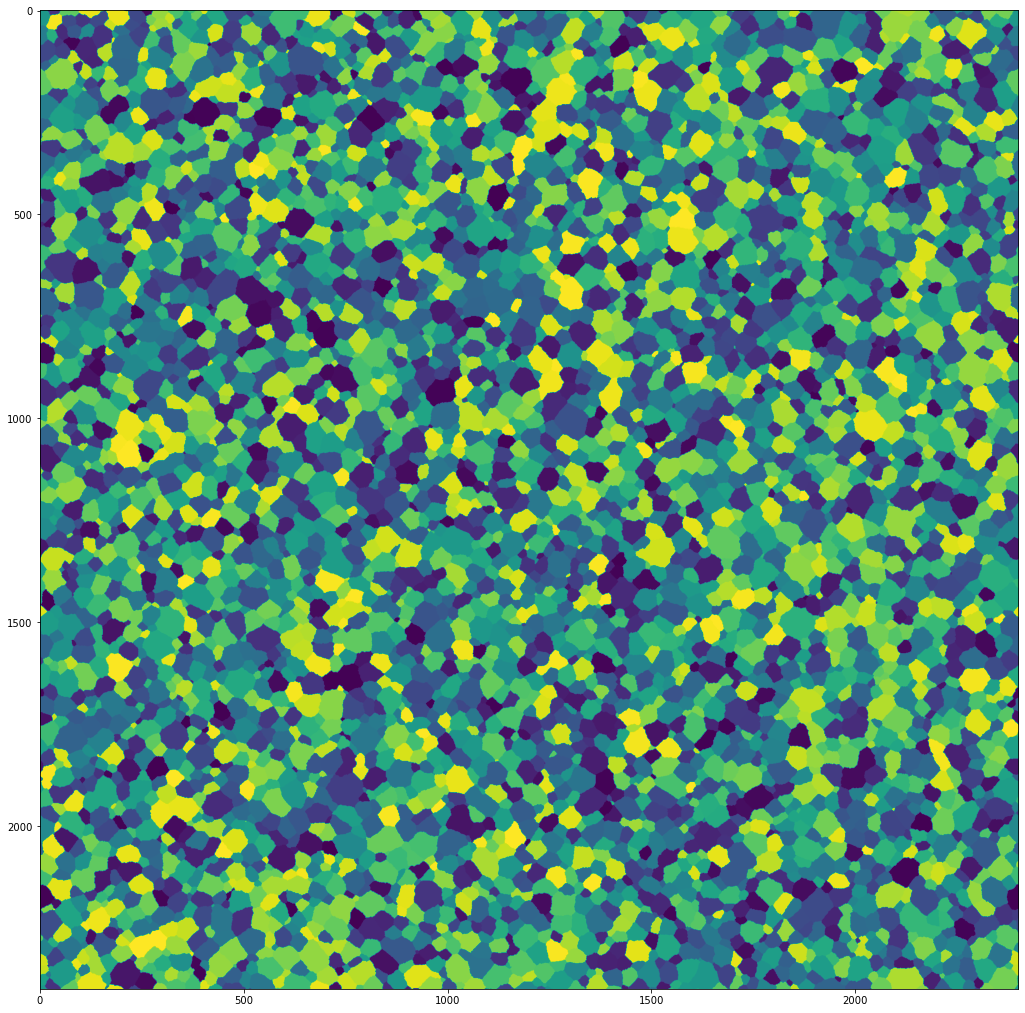

In [56]:
plt.figure()
fig = plt.figure(figsize=(18, 18))
plt.imshow(npy_file_aniso_ave[special_step_distribution_ave])

/scratch/local/22419590/ipykernel_2230553/3306200650.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection='polar')


the processor [0, 0] start...
the processor [0, 1] start...
the processor [0, 2] start...
the processor [0, 3] start...
the processor [1, 0] start...
the processor [1, 1] start...
the processor [1, 2] start...
the processor [1, 3] start...
process[0, 0] read 0 times and max qsize 0
my core time is 18.653027
res_back start...
my res time is 0.051391
process[0, 1] read 0 times and max qsize 0
my core time is 19.071704
res_back start...
my res time is 0.018746
process[0, 2] read 0 times and max qsize 0
my core time is 19.317602
res_back start...
my res time is 0.01651
process[0, 3] read 0 times and max qsize 0
my core time is 19.341707
res_back start...
my res time is 0.018014
process[1, 1] read 0 times and max qsize 0
my core time is 18.653502
res_back start...
my res time is 0.01739
process[1, 0] read 0 times and max qsize 0
my core time is 19.823368
process[1, 2] read 0 times and max qsize 0
my core time is 19.103572
res_back start...
my res time is 0.018021
res_back start...
my res ti

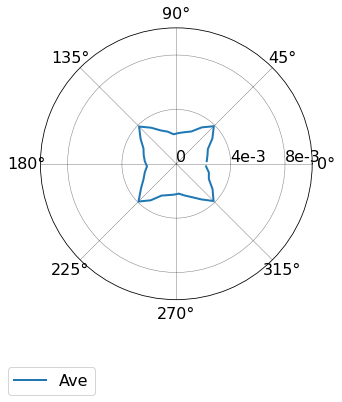

In [57]:

    # Start polar figure
    plt.close()
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca(projection='polar')

    ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=16)
    ax.set_thetamin(0.0)
    ax.set_thetamax(360.0)

    ax.set_rgrids(np.arange(0, 0.01, 0.004))
    ax.set_rlabel_position(0.0)
    ax.set_rlim(0.0, 0.01)
    ax.set_yticklabels(['0', '4e-3', '8e-3'],fontsize=16)

    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    ax.set_axisbelow('True')

    # Aniso - ave
    # Save temporary data for future plotting
    # data_file_name = f'/normal_distribution_data/Test_normal_distribution_iso_step{special_step_distribution_ave}.npz' # tmp data file name
    # if os.path.exists(current_path + data_file_name):
    #     inclination_npz_data = np.load(current_path + data_file_name)
    #     P = inclination_npz_data["P"]
    #     sites = inclination_npz_data["sites"]
    # else:
    newplace = np.rot90(npy_file_aniso_ave[special_step_distribution_ave,:,:,:], 1, (0,1))
    P, sites, sites_list = post_processing.get_normal_vector(newplace)
        # np.savez(current_path + data_file_name, P=P, sites=sites)
    slope_list = post_processing.get_normal_vector_slope(P, sites, special_step_distribution_ave, "Ave") # plot inclinaitn distribution
    # save inclination distribution figure
    plt.legend(loc=(-0.12,-0.35),fontsize=16,ncol=3)
    plt.show()
    # plt.savefig(current_path + "/figures/normal_distribution_poly_20k_after_removing_bias.png", dpi=400,bbox_inches='tight')














In [19]:
np.array([450,450,450]).astype('int')

array([450, 450, 450])

In [46]:
import numpy as np
interval = 5

offsets = np.array(np.meshgrid(
np.linspace(0,5,6),
np.linspace(0,5,6),
np.linspace(0,5,6),
)).T.reshape(-1, 3)

offsets

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 2., 0.],
       [0., 3., 0.],
       [0., 4., 0.],
       [0., 5., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [1., 2., 0.],
       [1., 3., 0.],
       [1., 4., 0.],
       [1., 5., 0.],
       [2., 0., 0.],
       [2., 1., 0.],
       [2., 2., 0.],
       [2., 3., 0.],
       [2., 4., 0.],
       [2., 5., 0.],
       [3., 0., 0.],
       [3., 1., 0.],
       [3., 2., 0.],
       [3., 3., 0.],
       [3., 4., 0.],
       [3., 5., 0.],
       [4., 0., 0.],
       [4., 1., 0.],
       [4., 2., 0.],
       [4., 3., 0.],
       [4., 4., 0.],
       [4., 5., 0.],
       [5., 0., 0.],
       [5., 1., 0.],
       [5., 2., 0.],
       [5., 3., 0.],
       [5., 4., 0.],
       [5., 5., 0.],
       [0., 0., 1.],
       [0., 1., 1.],
       [0., 2., 1.],
       [0., 3., 1.],
       [0., 4., 1.],
       [0., 5., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [1., 2., 1.],
       [1., 3., 1.],
       [1., 4., 1.],
       [1., 5

array([[-6, -6, -6],
       [-6, -5, -6],
       [-6, -4, -6],
       ...,
       [ 6,  4,  6],
       [ 6,  5,  6],
       [ 6,  6,  6]])